## Customer Segmentation

Customer Segmentation is the process of dividing your customer base into groups of similar characteristics. The idea is that by segmenting customers based on a number of features/characteristics rather than looking at each indvidual feature, you can save your data scientists/analysts' time and get a more global view of how your customers are different. 

Customer segmentation is usually done to aid the marketing team in their efforts to target these customers with email and promotions in an effort to increase revenue by providing a more personalized experience. The idea is that different customers each have different demands, but trying to meet each individual customer's demand is not scalable over hundreds or usually millions of customers. So finding clusters in your customer base can allow you to customize and cater to the interests of your customer base on a feasible level. You can think of it as a tradeoff between the scalability and personalization for this particular problem. 

To go into a bit of detail about the algorithm itself, k means attmepts to find clusters via the distance between points. So it clusters by finding points that are mathematically close (Euclidean distance is the metric for all the math heads out there) and assigning them a cluster. 

### 1. Import Packages

In [8]:
# Import our favorite data science packages
import os
import numpy as np
import pandas as pd
from scipy import stats

# Import the libraries needed to import data from UCI into pandas
import requests
import io

# We also will need a list of plotting libraries 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

# And this will allow us to see our plots within the Jupyter notebook rather than being taken to an outside window.
%matplotlib inline
#this is a cool trick to have better looking plots:
%config InlineBackend.figure_format = 'retina'

### Wholesale Customers Data Set:

**The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units on diverse product categories. For more information, please visit the following website: https://archive.ics.uci.edu/ml/datasets/wholesale+customers**

### 2. Data Collection

In [12]:
# Read data in from the source url
url_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
request=requests.get(url_name).content
df=pd.read_csv(io.StringIO(request.decode('utf-8')))
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


**Attribute Information**:

1)	FRESH: annual spending on fresh products (Continuous)

2)	MILK: annual spending on milk products (Continuous)

3)	GROCERY: annual spending on grocery products (Continuous)

4)	FROZEN: annual spending on frozen products (Continuous) 

5)	DETERGENTS_PAPER: annual spending on detergents and paper products (Continuous) 

6)	DELICATESSEN: annual spending on and delicatessen products (Continuous)

7)	CHANNEL: customers Channel - Horeca (Hotel/Restaurant) or Retail channel (Nominal) 

8)	REGION: customers Region Lisabon, Porto or Other (Nominal) 


REGION	Frequency 
Lisbon	77 
Oporto	47 
Other Region	316 
Total	440 

CHANNEL	Frequency 
Horeca	298 
Retail	142 
Total	440 



In [14]:
# Name the categorical variables. We do this because sklearn doesn't accept String variables.
df["region_name"] = df["Region"].map({1:"Lisabon", 2:"Porto", 3:"Other"})
df["channel_name"] = df["Channel"].map({1:"Hotel/Restaurant", 2:"Retail"})

### 2. Define Goal:

**- Visualize the data and identify correlations between sales.**

**- Segment and cluster the wholesale customers in terms of annual sales to identify patterns.**

In [4]:
#eliminating some outliers for better visualization:
num_df = df[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]]
# We use the z score method to find outliers and then remove them from the dataset.
good_index = num_df[(np.abs(stats.zscore(num_df)) < 2.5).all(axis=1)].index
df = df.loc[good_index]

### 3. Visualize:

#### Scatterplots:

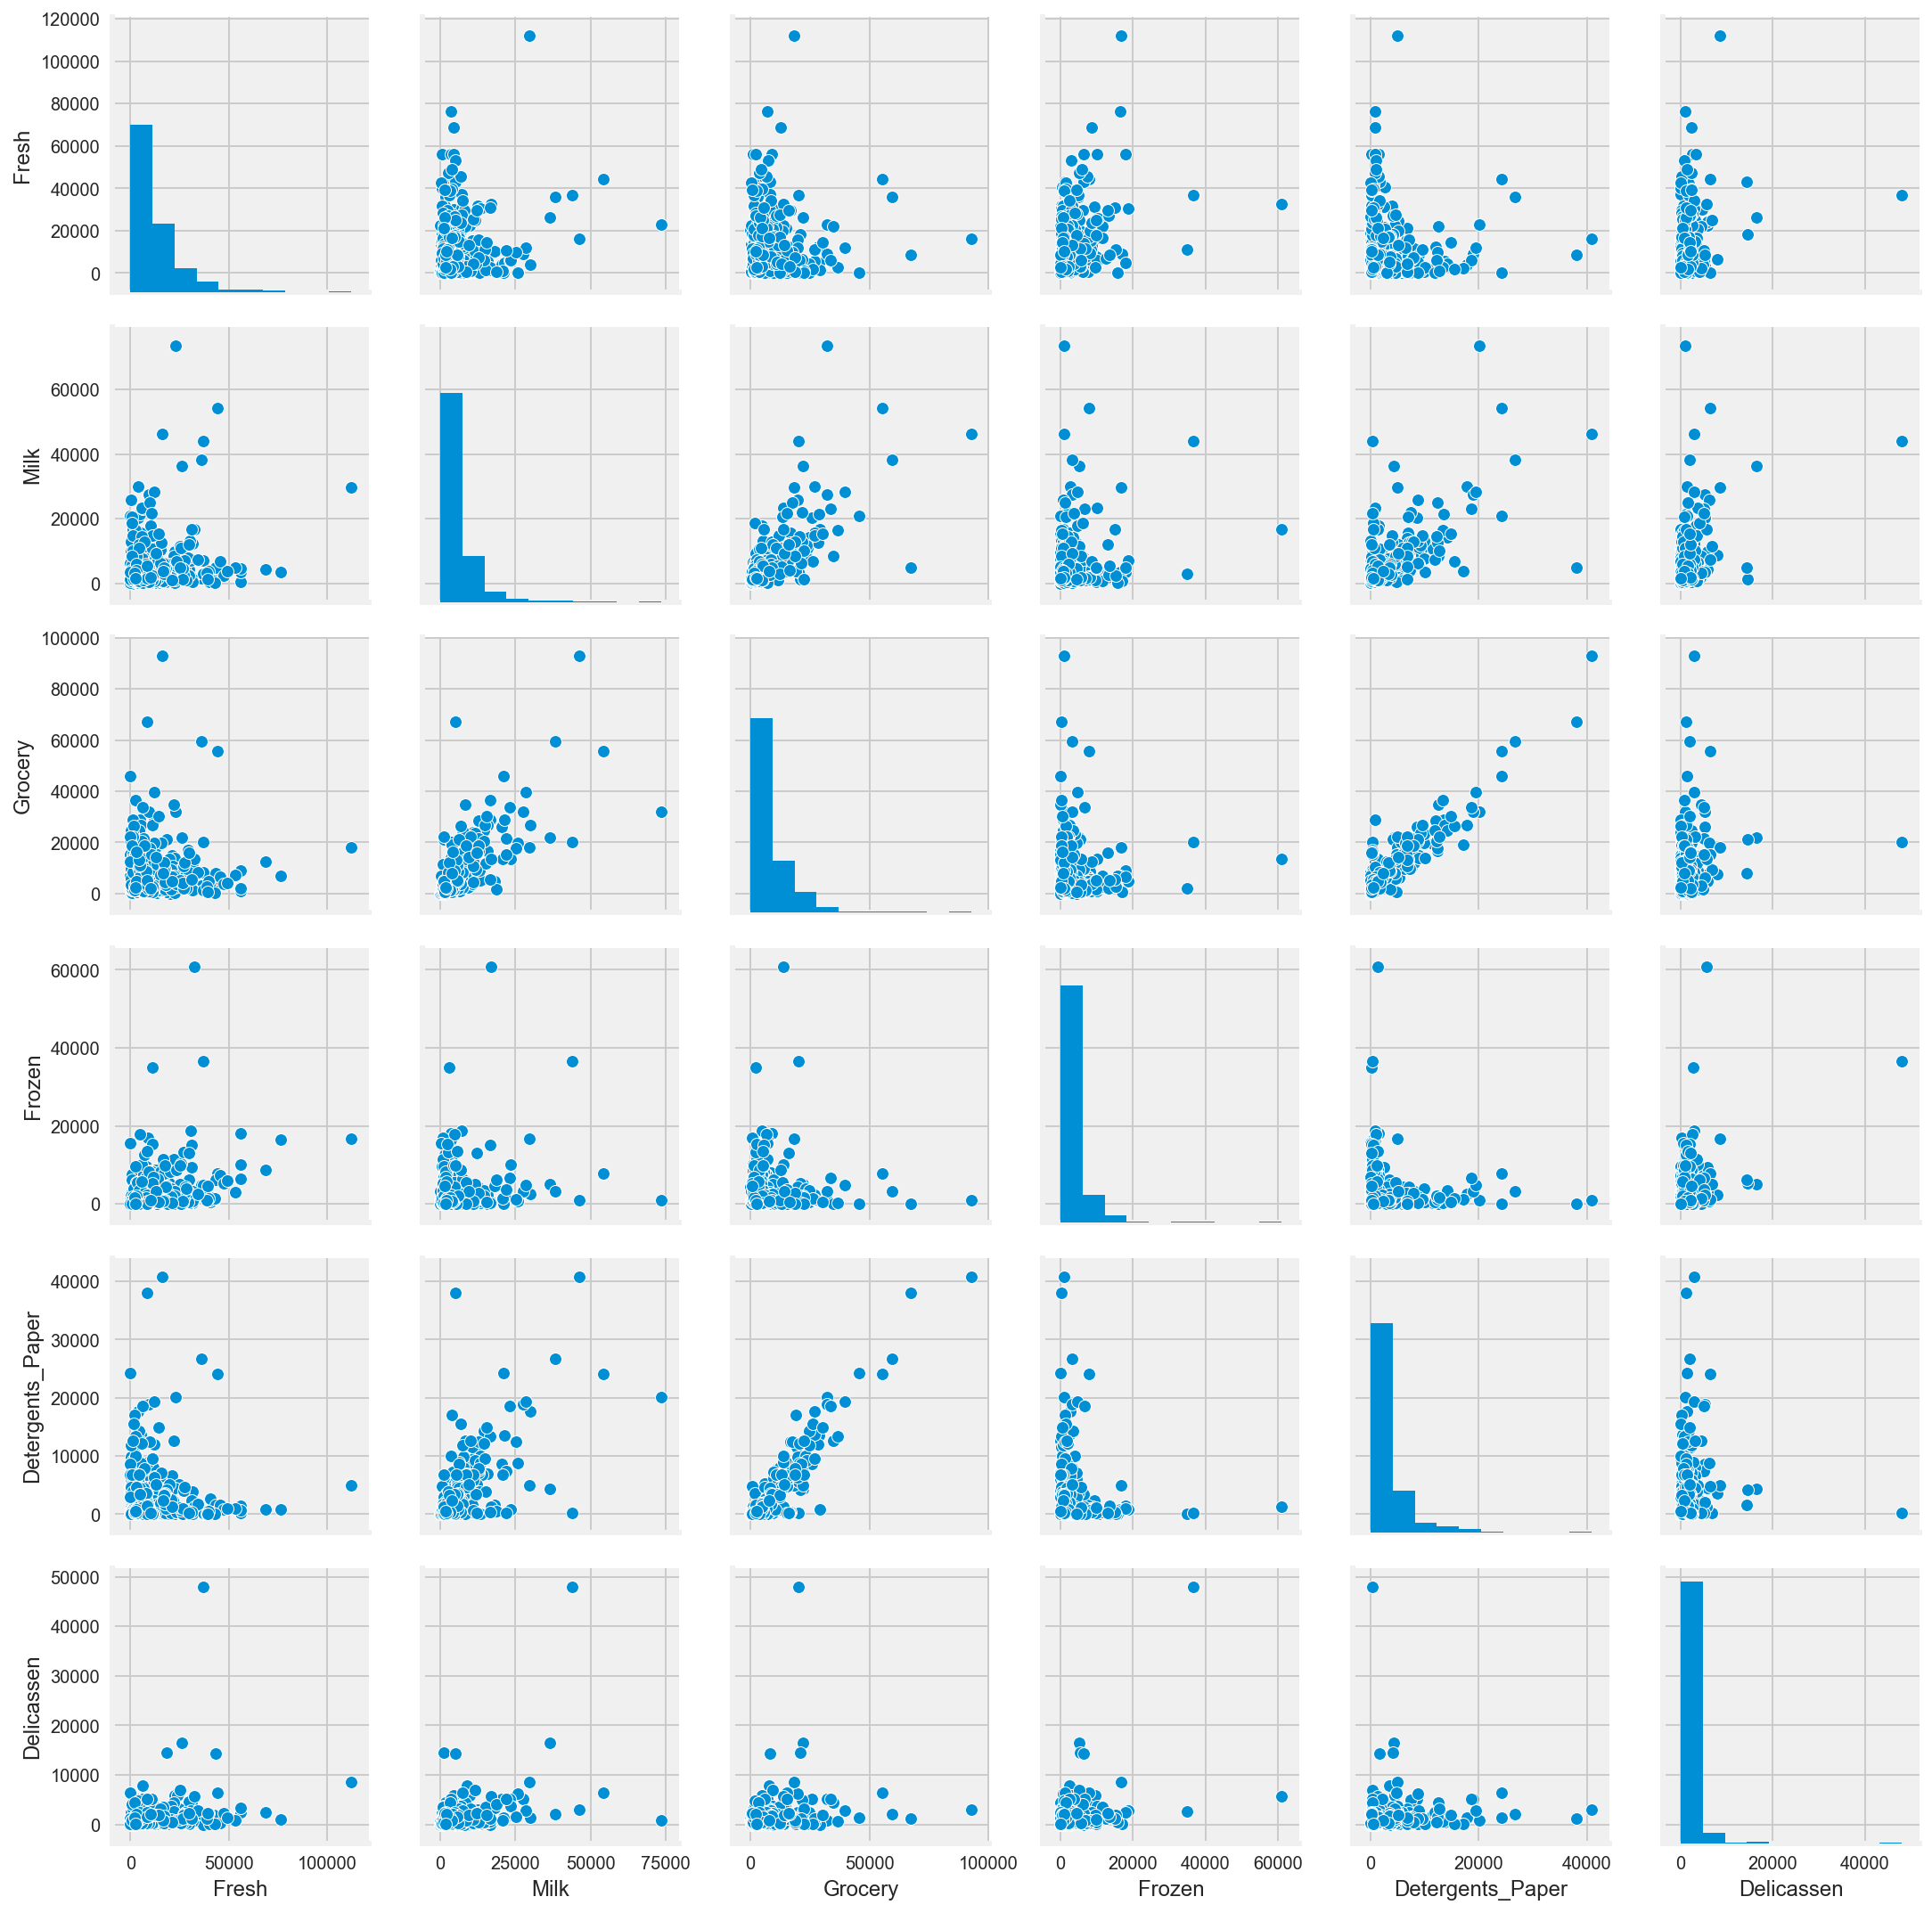

In [17]:
sns.pairplot(df.loc[:,"Fresh":"Delicassen"])

#### Now let's look at the correlations. Correlations will show how different buying patterns move. So for example, a high correlation bewteen item A and item B would indicate that the customers who buy a lot of item A tend to buy a lot of item B as well (and vice versa).

In [18]:
correlations = df.loc[:,"Fresh":"Delicassen"].corr()

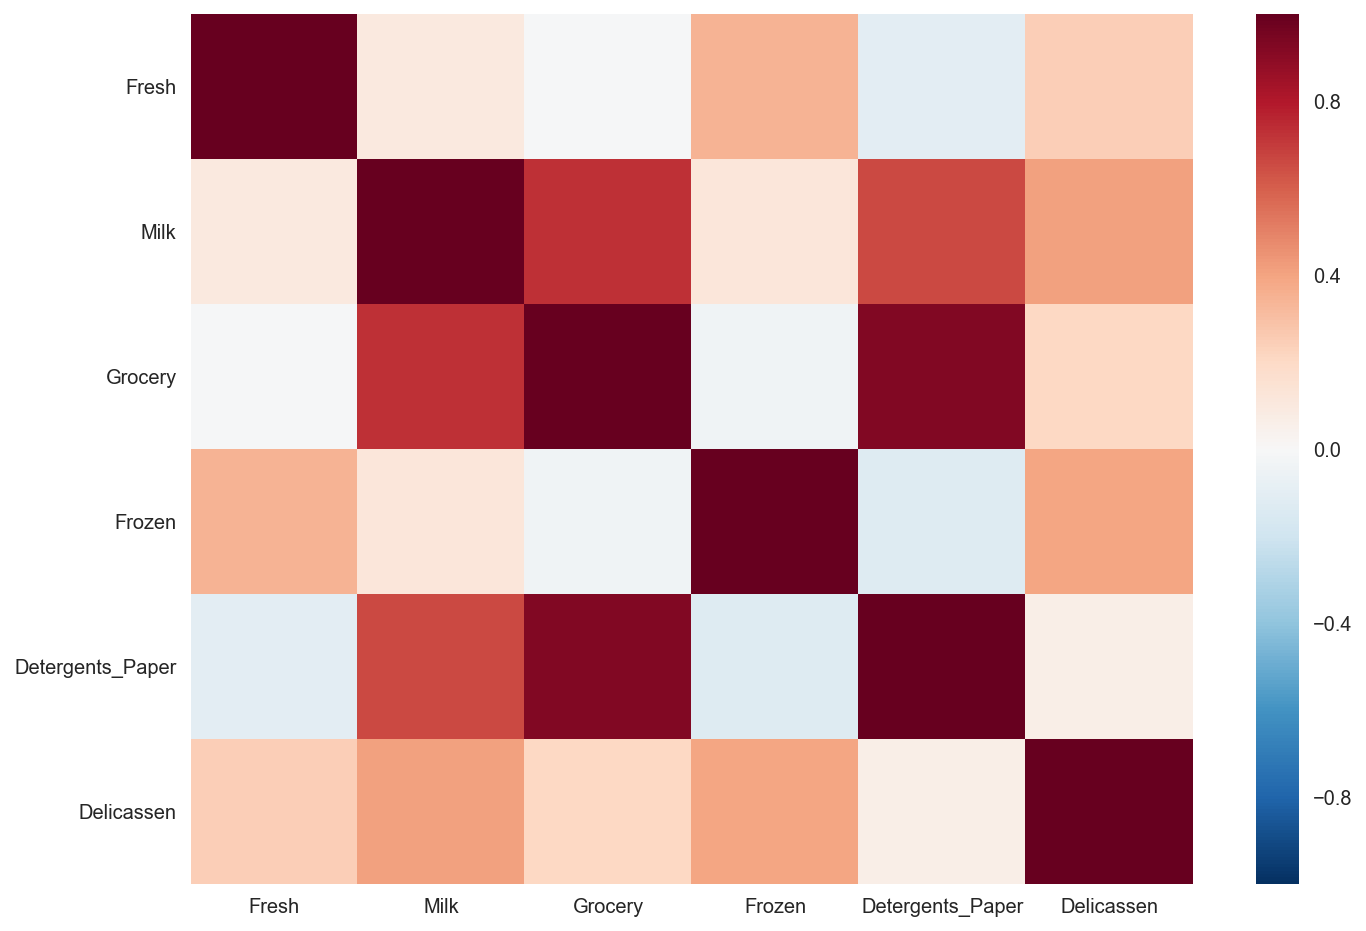

In [19]:
plt.figure(figsize = (10, 8))
sns.heatmap(correlations)

### Based on the scatterplots and the correlation heatmap we observe the following:


- **Milk and Gorcery Sales are positively correlated - meaning clients who buy a lot of one buy a lot of the other**
- **Grocery and Detergents/Paper are positively correlated as well**
- **People don't tend to buy a lot of Detergents/Paper. **

#### So what we're going to do look at the plots based on the channel the customer purchased from. The idea is to see if certain customers who purchased from a certain channel hae any common purchasing patterns. 

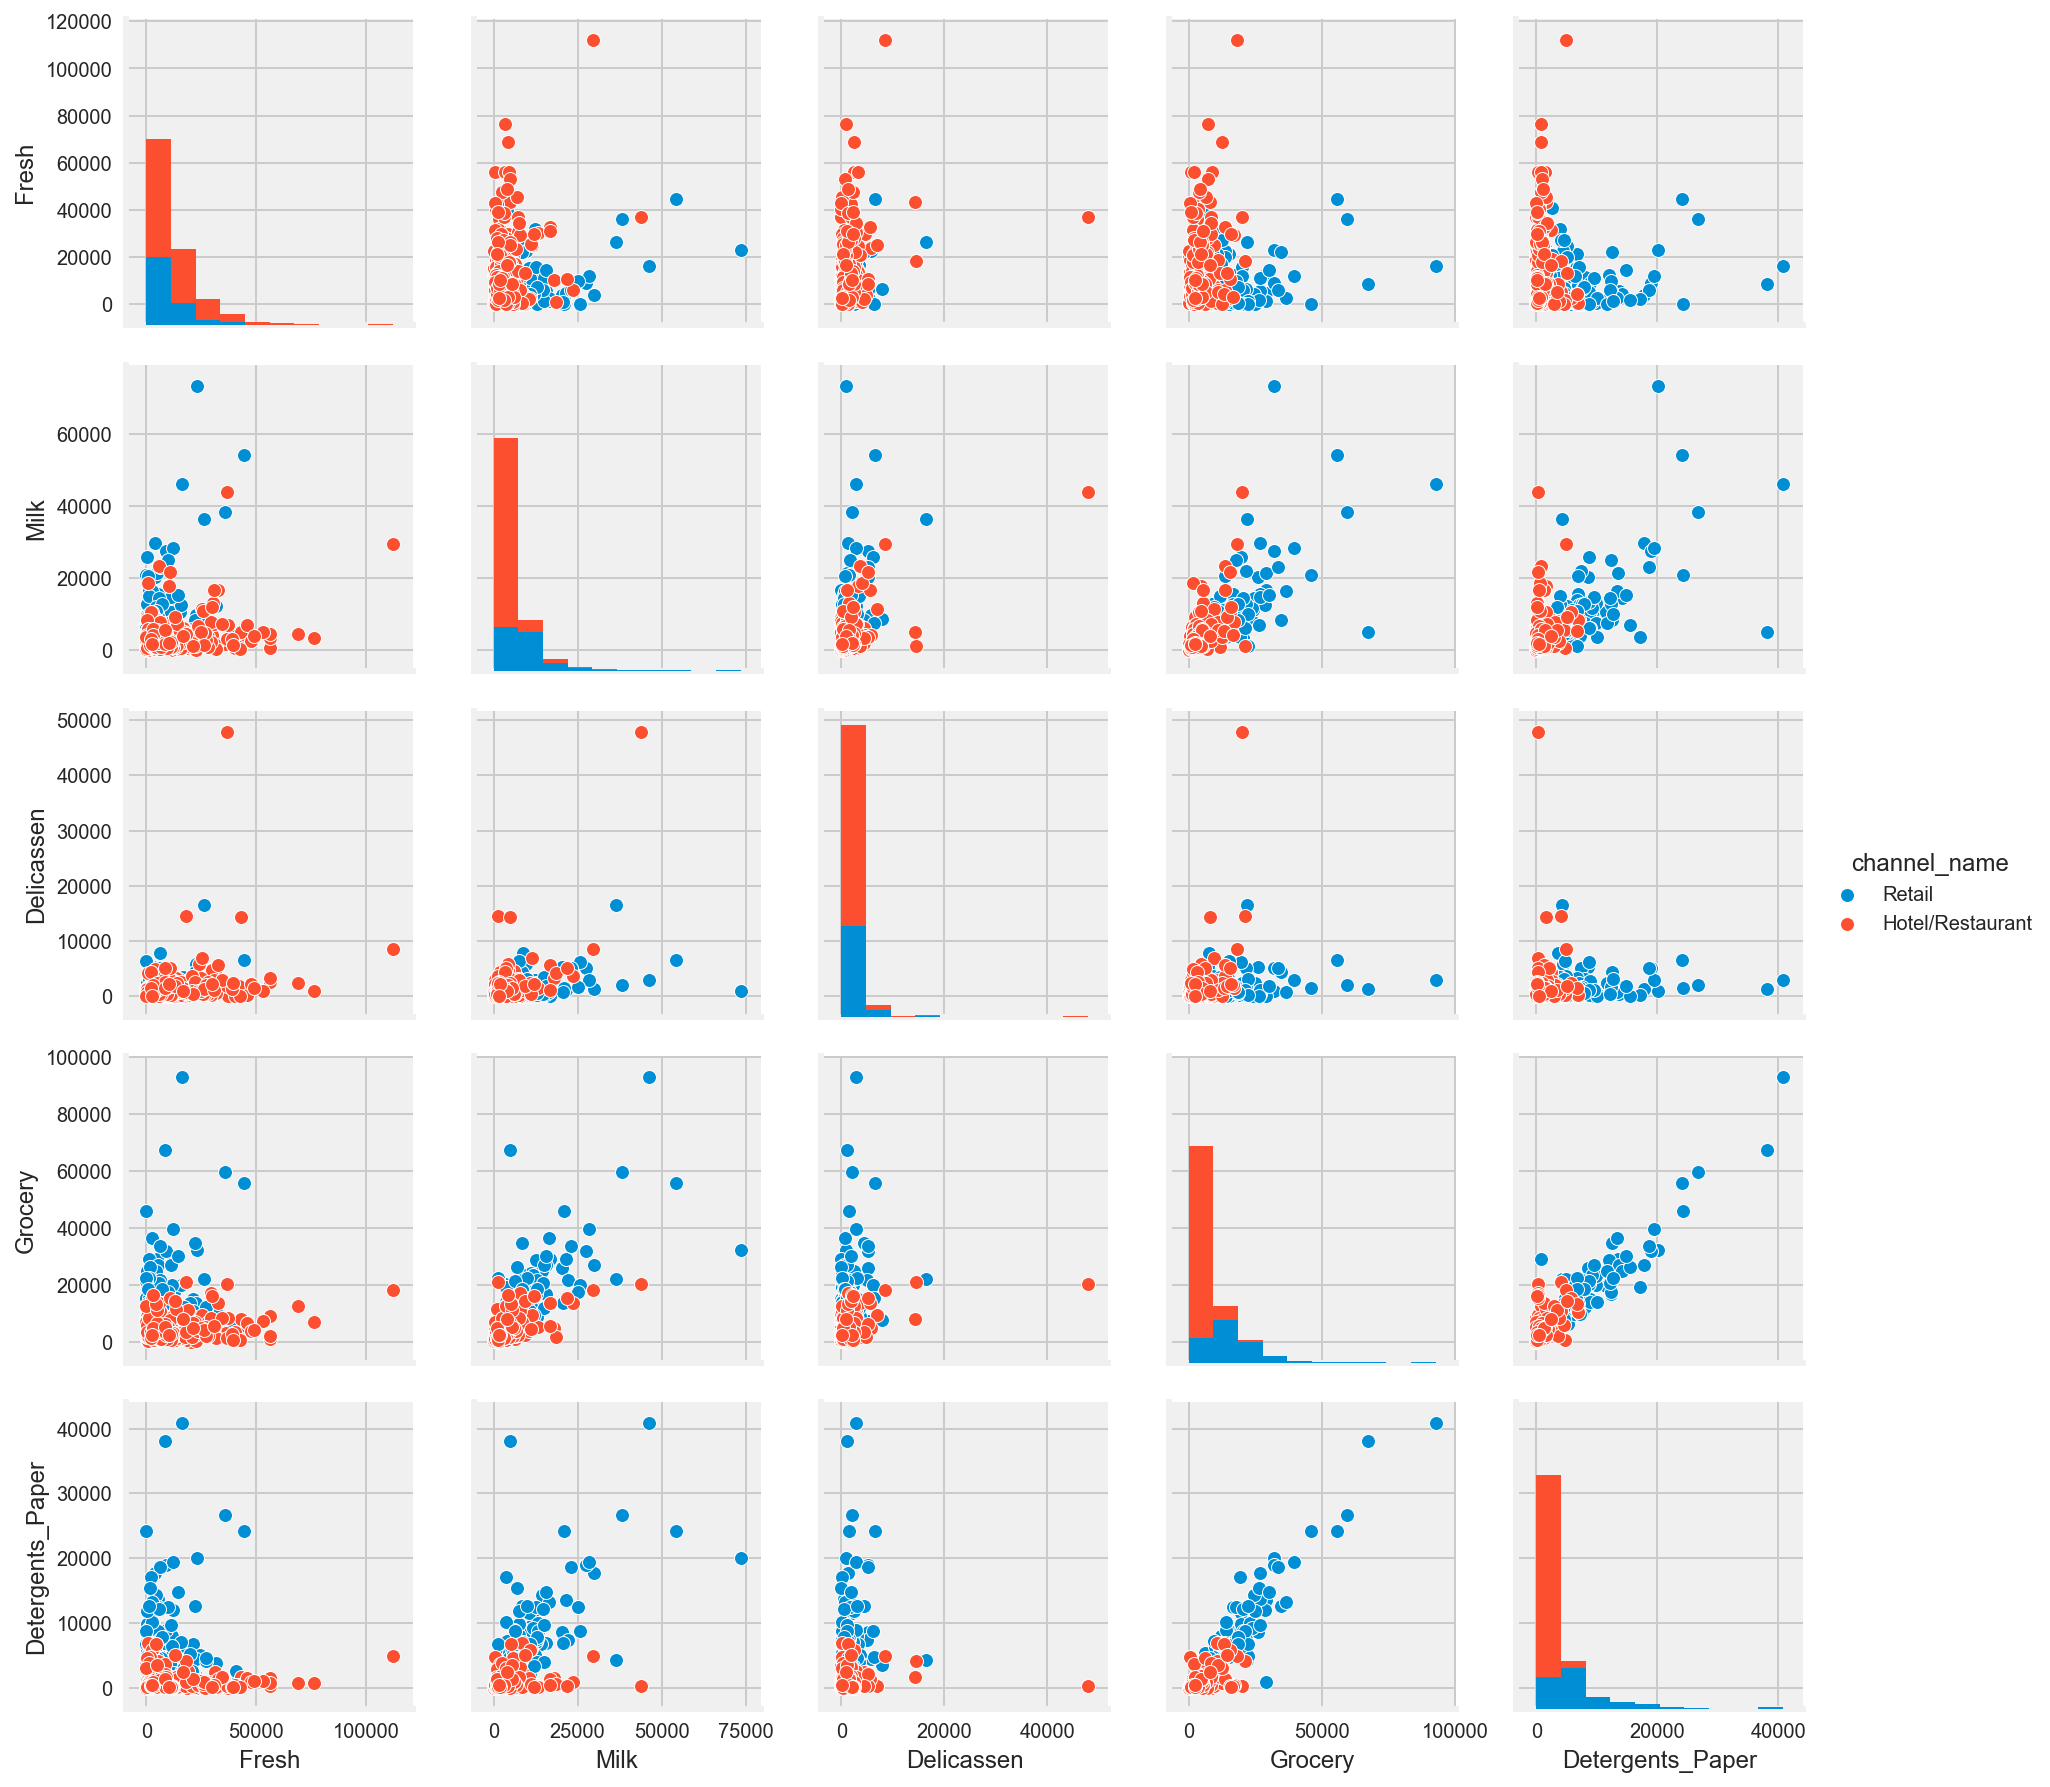

In [20]:
sns.pairplot(df[["Fresh", "Milk", "Delicassen", "Grocery", "channel_name", "Detergents_Paper"]], hue = "channel_name")

#### From the graphs, we notice something:
- **We can see a fairly clear split between the two channels in that the Hotel channel tends to buy in lesser quantities than the Retail channel for the Detergents/Paper and Grocery. This makes sense because Retailers sell in much higher volumes than hotels. However, Hotels tend to purchase more Fresh foods than Retailers. This si fairly surprising given that retailers specialize in selling produce. For Milk and Deli, there really isn't a difference.**

In [21]:
df.groupby("channel_name").mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
channel_name,,,,,,,,
Hotel/Restaurant,1.0,2.510067,13475.560403,3451.724832,3962.137584,3748.251678,790.560403,1415.956376
Retail,2.0,2.612676,8904.323944,10716.500000,16322.852113,1652.612676,7269.507042,1753.436620


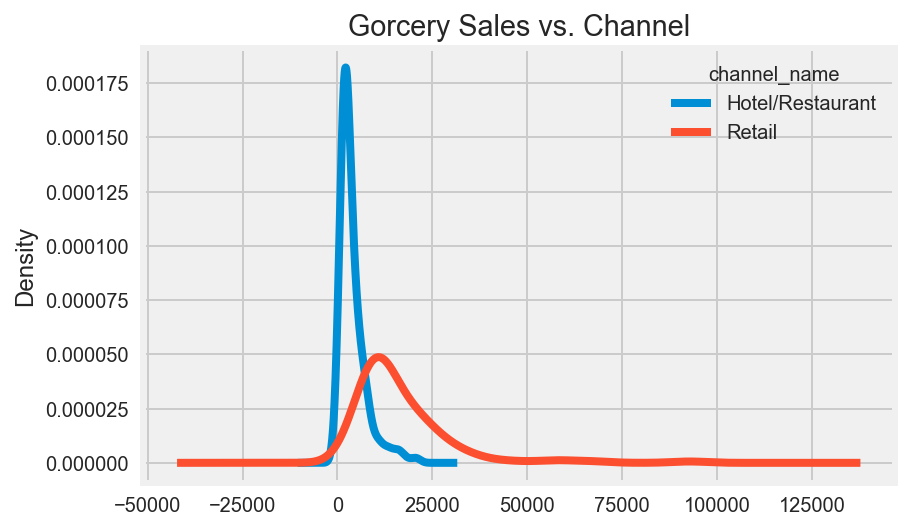

In [22]:
df[["Grocery", "channel_name"]].pivot(columns = "channel_name", values = "Grocery").plot.density()
plt.title("Gorcery Sales vs. Channel")

### Taking a closer view of the data using the table and the visalization above, we can observe the following:

- **Grocery, Milk, and Detergents/Paper	have higher sales for the Retail channel name over the Hotel/Restaurant channel.**
- **For Fresh Produce and Delicassen the differences aren't very significant between the Hotel/Restaurant and Retail channels**
- **The overall distributions of the Hotel and Retail sections are very different. The Retail distribution has much heavier tails (higher Kurtosis or Platykurtic) than the hotel (which is almost Gaussian/Normal) **

## 4. Customer Segmentation:

Here is where the magic happens: We will use the KMeans algorithm to cluster the customers based on how much they buy in the different categories. So based on their order quantities, we will see if there's some latent feature that allows us to cluster the customers.

In [24]:
# Load the libraries from sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

In [25]:
X = df.loc[:,"Fresh":"Delicassen"]
X.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [14]:
# We first need to scale the data with the MinMaxScaler because we want k means to treat the variables as having the same
# scale. What this means is that if we attempt to for example run k means with a dataset that has 2 features: housing price
# and temperatire, the algorithm will focus more on housing price because technically, there's more variance because the 
# values are larger.

kmeans = make_pipeline(MinMaxScaler(),
                       KMeans(n_clusters=4, random_state = 4))

In [15]:
# We're going to fit the algorithm to the dataset.
kmeans.fit(X)

Pipeline(steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=4, tol=0.0001, verbose=0))])

In [16]:
# We're now going to add the cluster assignments to the dataset as features for easier visualization. Adding the clusters
# can also be used to potentially increase the classification accuracy or lower the RSME (or whatever metric you choose to
# use) for regression problems.

X["clusters"] = kmeans.named_steps["kmeans"].labels_

### Visualizing the Clusters:

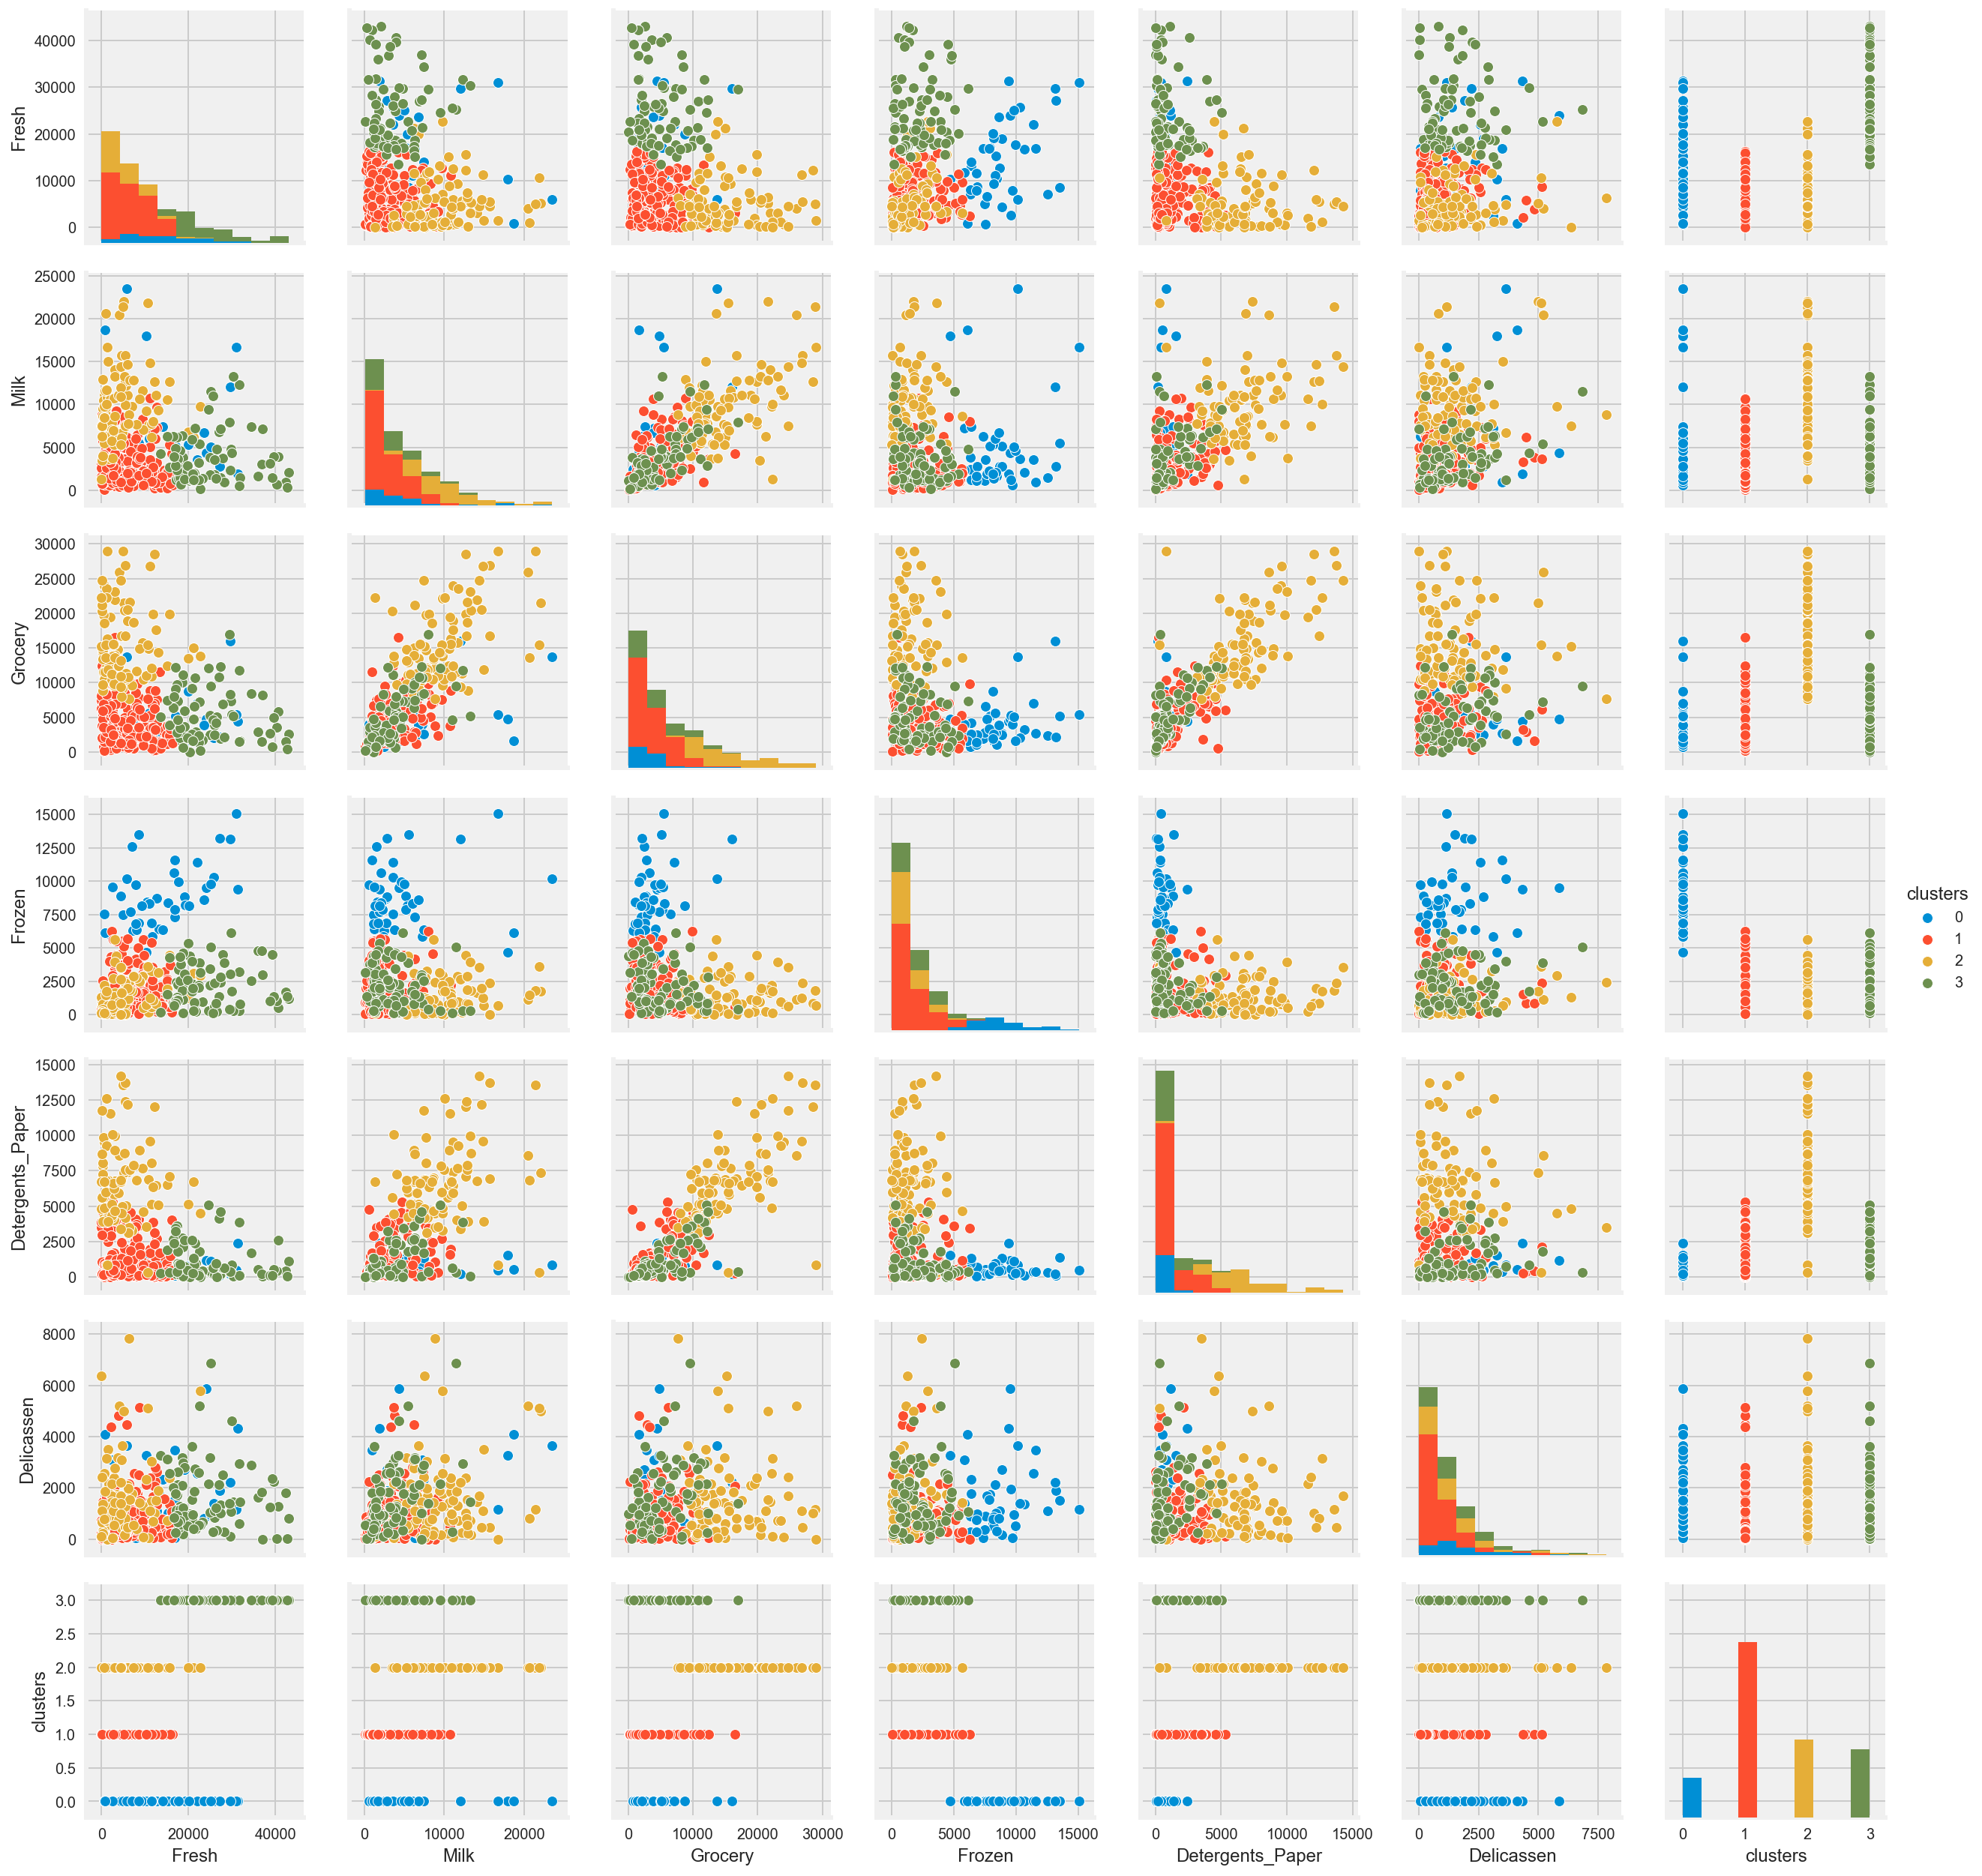

In [17]:
sns.pairplot(X, hue = "clusters")

We can get some intuition on the clusters even just by looking at the scatterplots. Let's look at the one more closely:

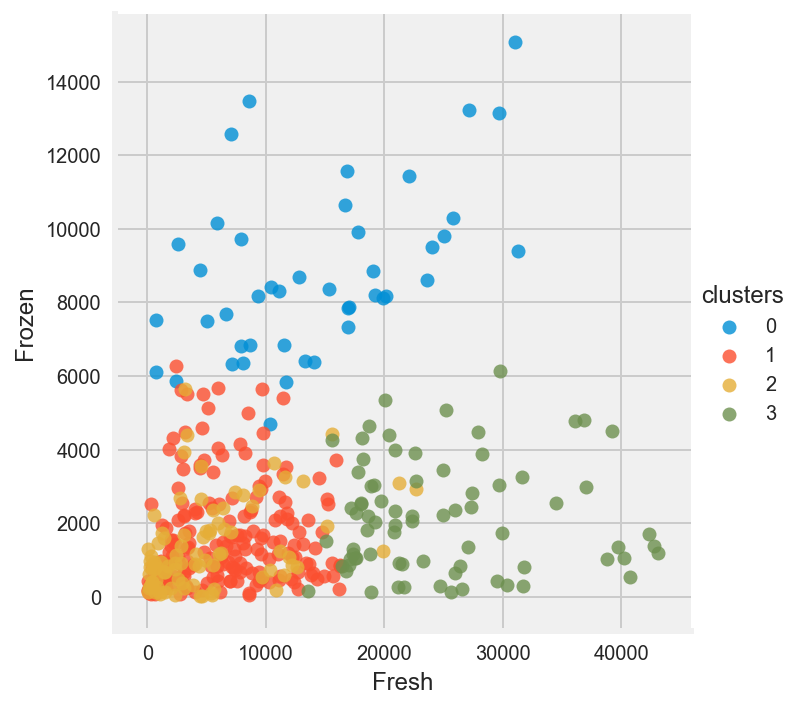

In [18]:
sns.lmplot(x = "Fresh", y = "Frozen", data = X, hue = "clusters", fit_reg = False)

We observe the following based on the scatterplot above:

- ** Cluster 1 and 2 are mostly clients who buy less Fresh and Frozen products**

- ** Clients in Cluster 3 buy a lot of Frozen products but not a lot of Fresh Products**

- ** Clients in Cluster 0 clients buy a lot of Fresh but not a lot of Frozen Products**

### Interpreting the Segments:

Let's look at the center of each cluster and see what the coefficients are - the largest coefficients will be the dominant features for that specific cluster so we can get an intuition of what dimensions are important for each cluster:

In [19]:
centers = kmeans.named_steps["kmeans"].cluster_centers_

In [20]:
centers = pd.DataFrame(centers, columns = X.columns[:6])

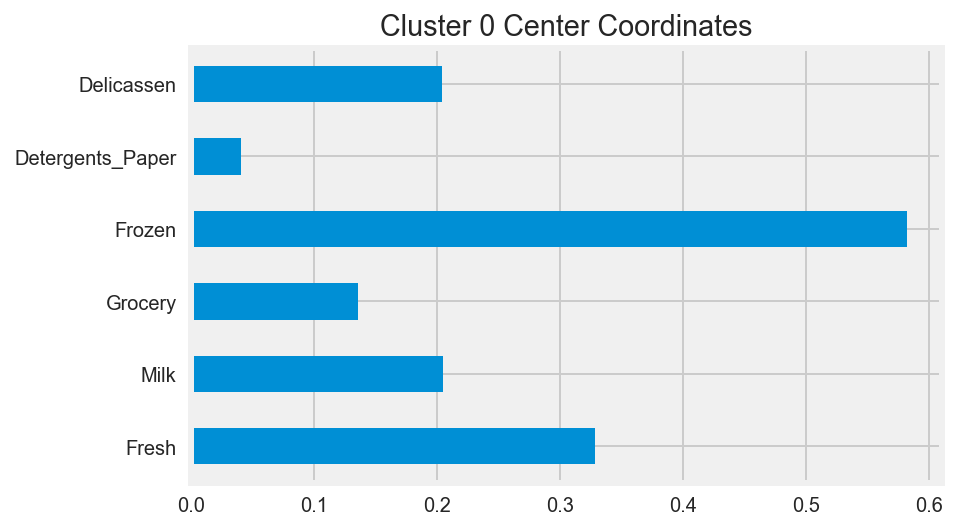

In [21]:
centers.iloc[0].plot(kind = "barh")
plt.title("Cluster 0 Center Coordinates")

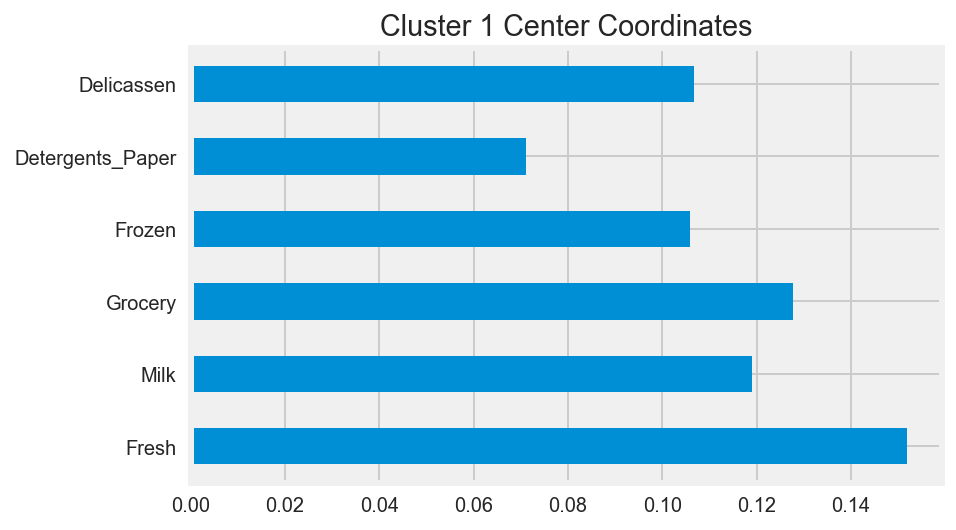

In [22]:
centers.iloc[1].plot(kind = "barh")
plt.title("Cluster 1 Center Coordinates")

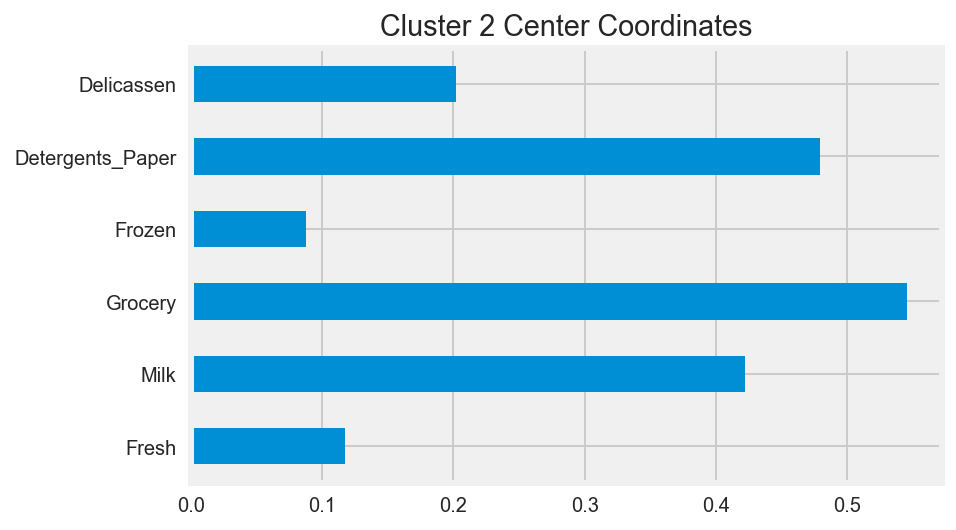

In [23]:
centers.iloc[2].plot(kind = "barh")
plt.title("Cluster 2 Center Coordinates")

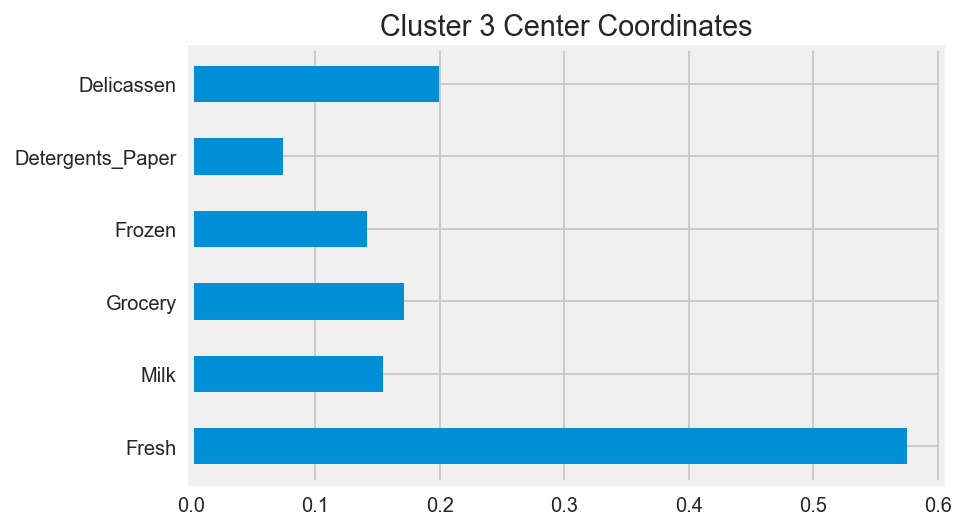

In [24]:
centers.iloc[3].plot(kind = "barh")
plt.title("Cluster 3 Center Coordinates")

Based on the size of the bars in the barplots above we can get an idea of the different important features in each cluster:

- **Cluster 0: Clients who spend a lot in the Frozen Categories**
- **Cluster 1: A balanced cluster - clients with roughly similar buying habits across the categories - leaning toward the Grovery/Milk/Fresh categories however**
- **Cluster 2: Clients who spend a lot in the Grocery + Detergents + Milk Categories and less in all the other categories**
- **Clsuter 3: Clients who spend a lot in the Fresh Category and less of everything else**

### We can also play around with the number of clusters - let's try only 2:

In [34]:
X = df.loc[:,"Fresh":"Delicassen"]
kmeans = make_pipeline(MinMaxScaler(),
                       KMeans(n_clusters=2, random_state = 4))
kmeans.fit(X)
#add the clusters to the dataframe for easier visualization:
X["clusters"] = kmeans.named_steps["kmeans"].labels_


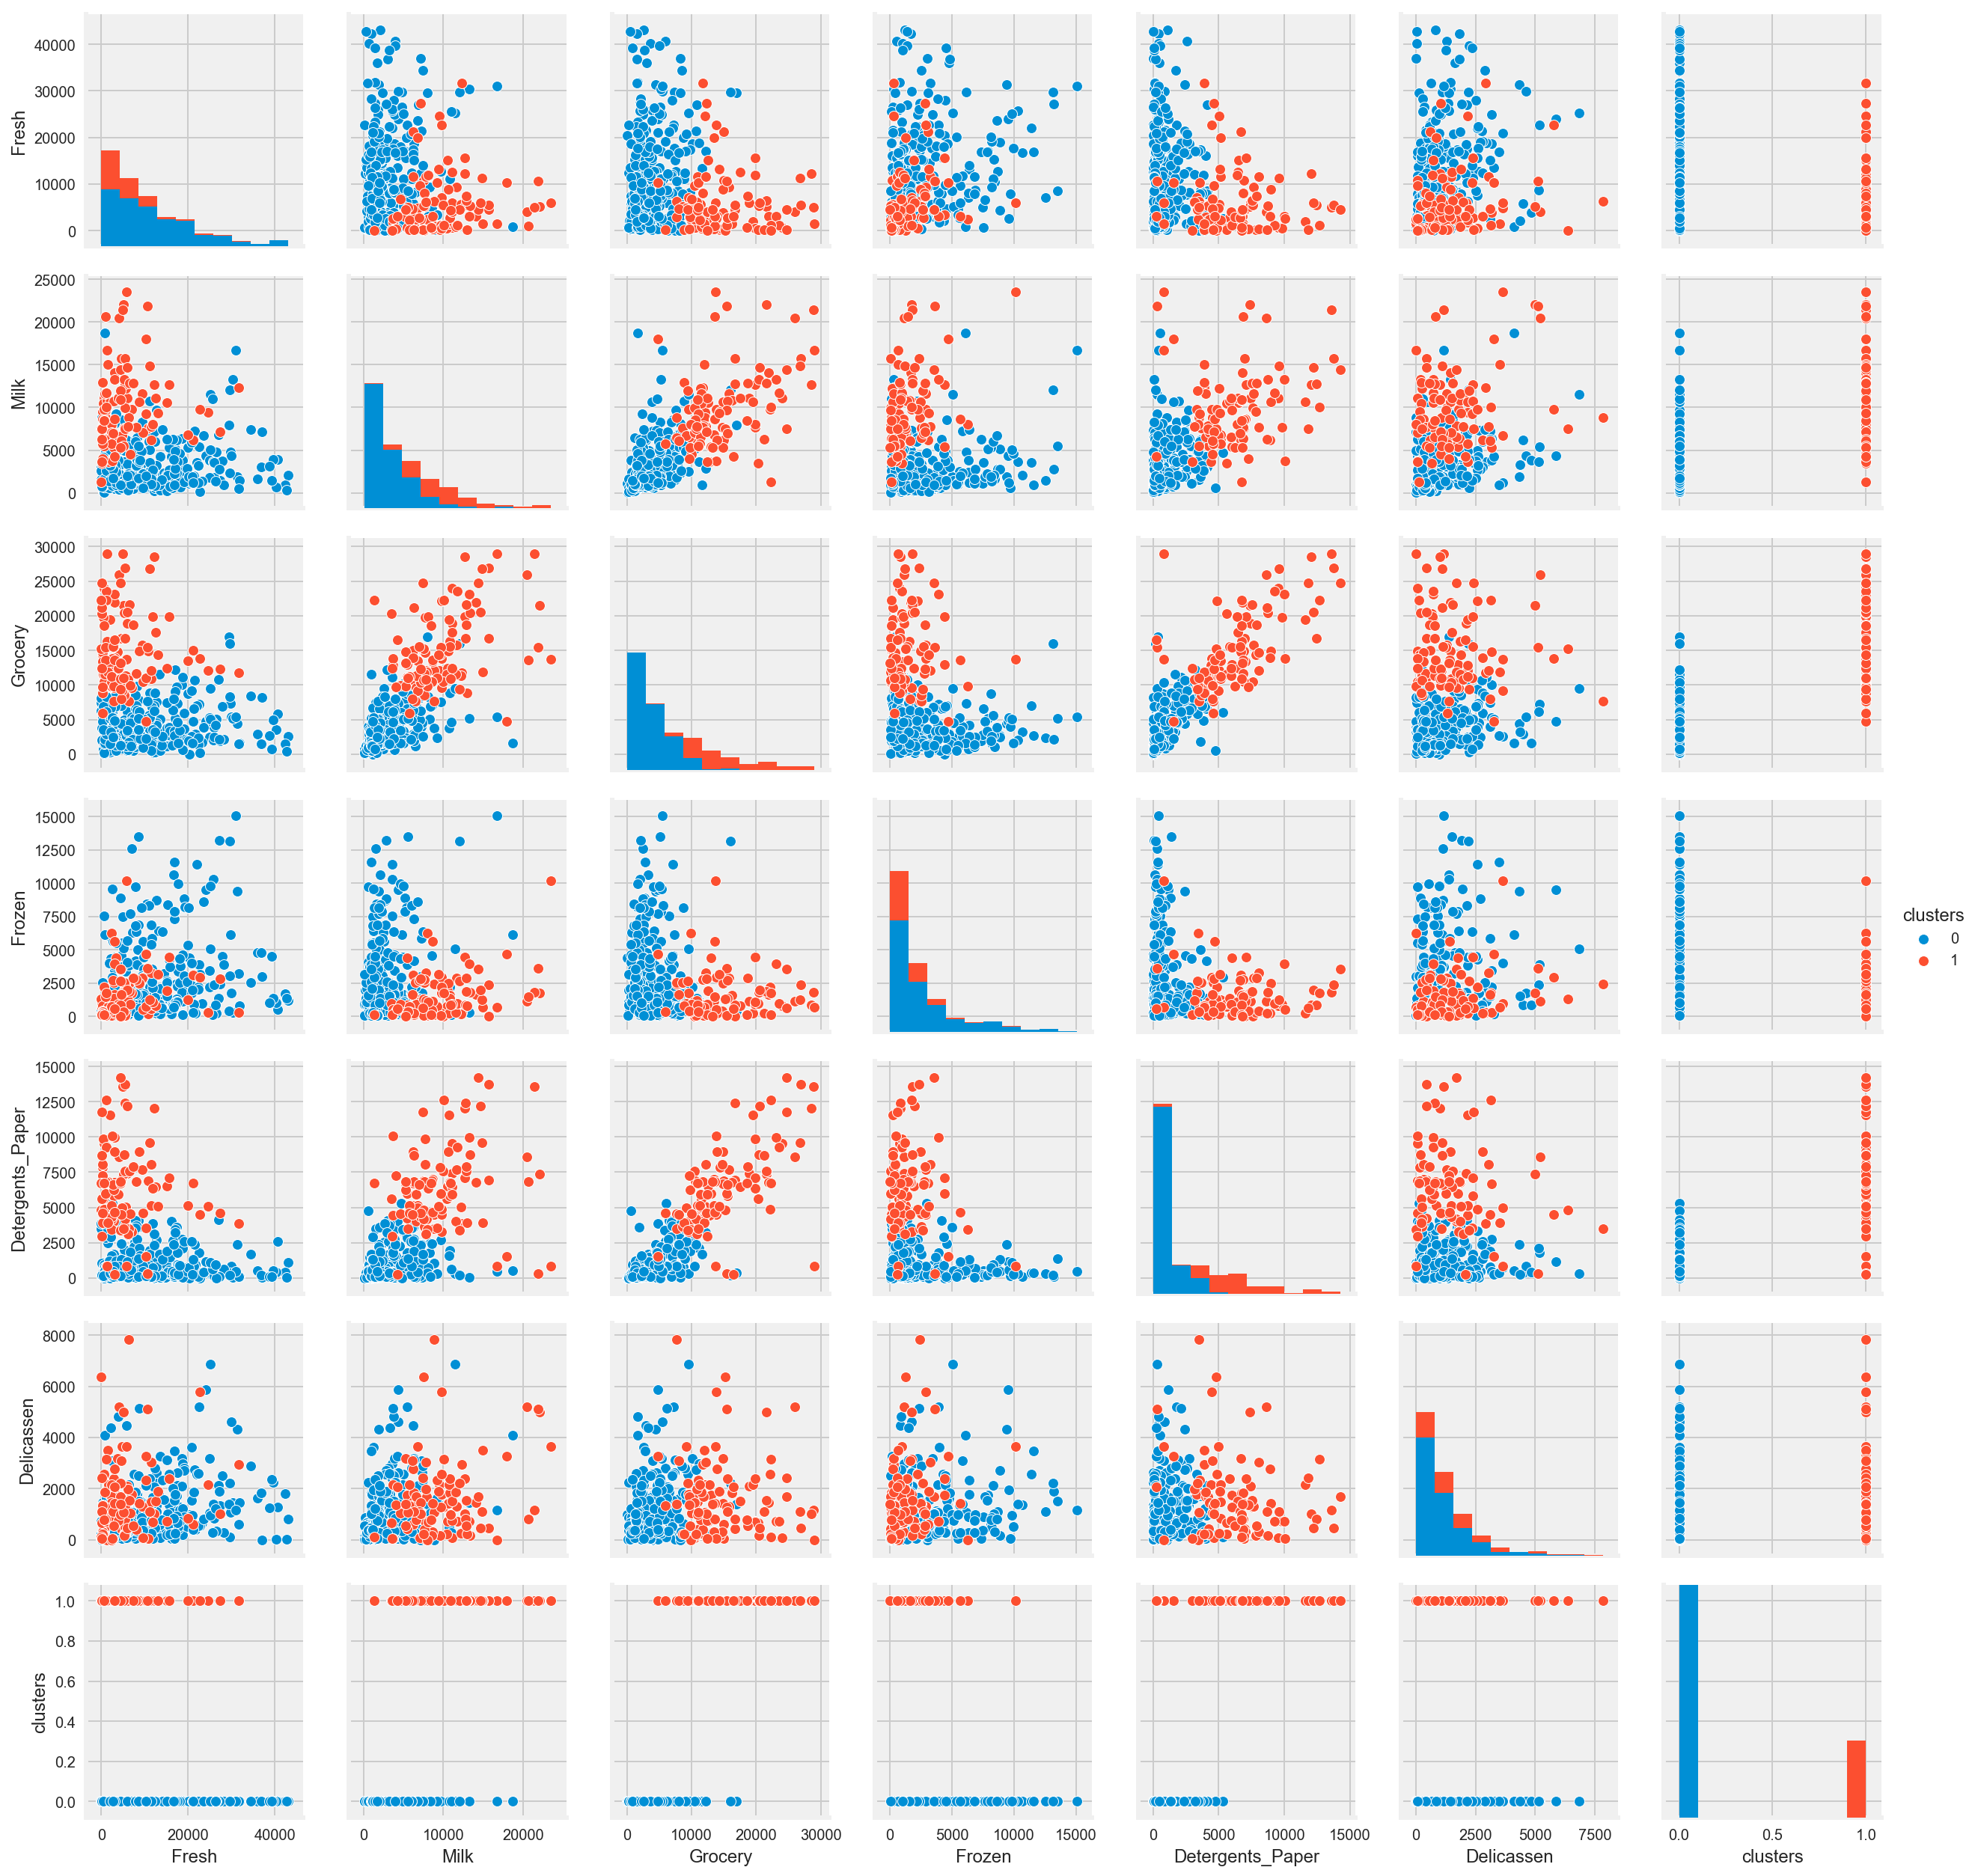

In [26]:
sns.pairplot(X, hue = "clusters")

In [27]:
centers = kmeans.named_steps["kmeans"].cluster_centers_

In [28]:
centers = kmeans.named_steps["kmeans"].cluster_centers_
centers = pd.DataFrame(centers, columns = X.columns[:6])

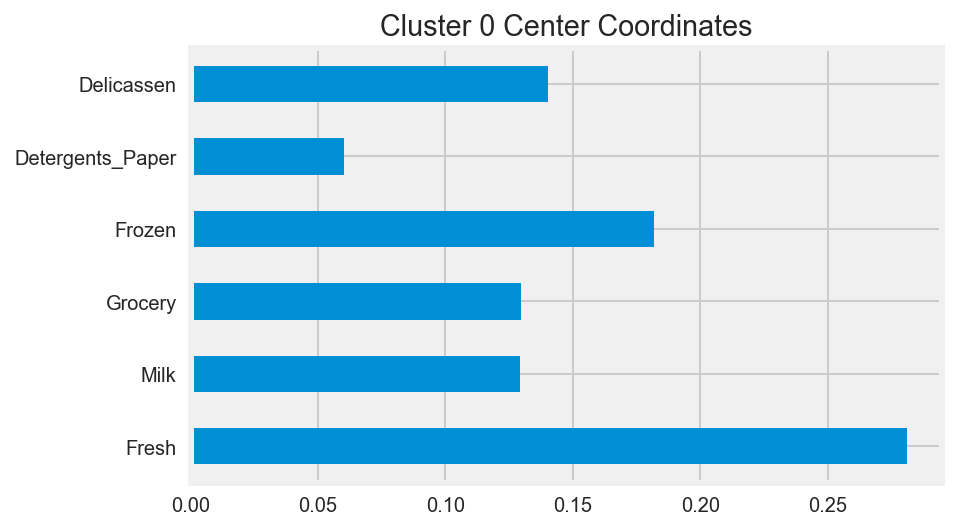

In [29]:
centers.iloc[0].plot(kind = "barh")
plt.title("Cluster 0 Center Coordinates")

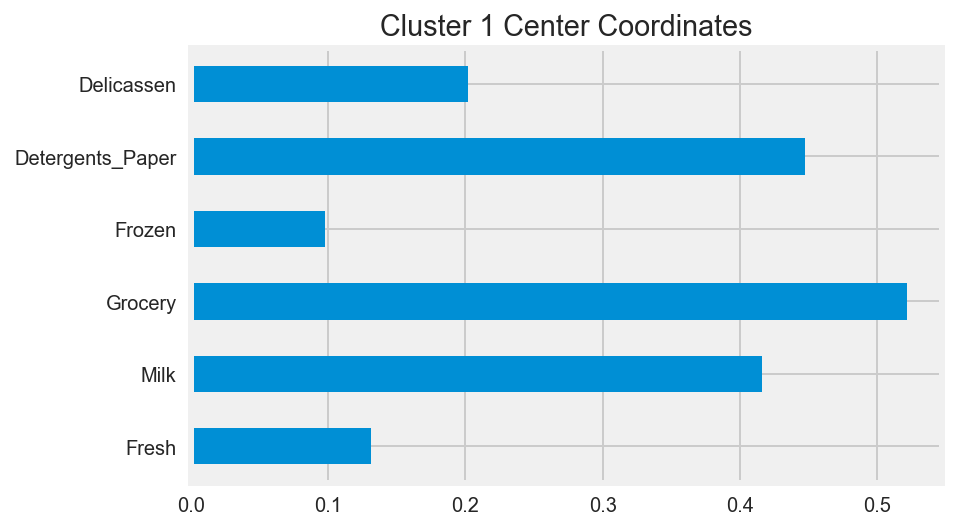

In [30]:
centers.iloc[1].plot(kind = "barh")
plt.title("Cluster 1 Center Coordinates")

We see the separation here:
- **Cluster 1 - Clients who spend a lot in the Detergents, Grocery, and Milk Categories**
- **Cluster 0 - Clients who spend a lot in the Fresh Category and slighlty above average in Frozen**

### Relationship between Segmenting and predifined categories like Channel:
We can see how our clusters compare with other information in the data - for example how are the clusters related to the Channel?

In [35]:
df["cluster"] = X["clusters"]

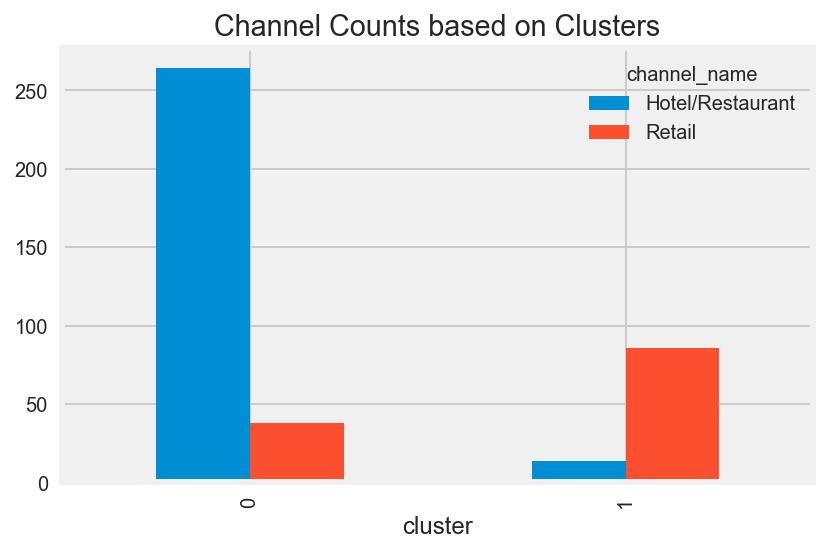

In [36]:
df.groupby(["cluster", "channel_name"])["Frozen"].count().unstack().plot(kind = "bar")
plt.title("Channel Counts based on Clusters")

In [37]:
df.groupby(["cluster", "channel_name"])["Frozen"].count()

cluster  channel_name    
0        Hotel/Restaurant    264
         Retail               38
1        Hotel/Restaurant     14
         Retail               86
Name: Frozen, dtype: int64

We observe the following:

- **Cluster 0 contains 87%  Hotel/Restaurant clients**

- **Cluster 1 has 86% Retail Clients **

**So our customer segmentation has identified and learned the notion of different channels - in this case Hotel\Restaurant vs. Retail:**

- **Cluster 1 is mostly Retail with customers who spend a lot on Detergents, Grocery, and Milk Categories**
- **Cluster 0 is mostly Hotel/Restaurant with clients who spend a lot on the Fresh Category and slighlty above average in Frozen**

The best part is that the clustering algorithm did not have acces to the Channel Labels directly - we only clustered on the spending habits of the clients - the fact that the algorithm managed to segment the clients roughly by channel is remarkable.